In [25]:
import pandas as pd
import numpy as np

data = pd.read_csv("nano.csv", encoding="latin1", engine = 'python')

#df = pd.DataFrame(columns=['Size','COLOUR','caTegory'])
#data = data['Name'].astype(str).str.lower()
data = data.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
data = data.fillna(method="ffill")
data.head(20)

,Name,Class
0,a,nonnano
1,b,nonnano
2,nano,nano
3,fullerene,nano
4,nanometer,nano
5,cnt,nano
6,nanotube,nano
7,graphene,nano
8,dendrimer,nano
9,origami,nano


In [2]:
words = list(set(data["Name"].values))
words.append("ENDPAD")
n_words = len(words); n_words

4982

In [3]:
tags = list(set(data["Class"].values))
n_tags = len(tags); n_tags

2

In [10]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Name"].values.tolist(),
                                                     s["Class"].values.tolist())]
        self.grouped = self.data.groupby("Name").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(data)

In [12]:
sent = getter.get_next()

In [13]:
print(sent)

None


In [14]:
sentences = getter.sentences
print(sentences)

[[(' well', 'NANO')], [('#NAME?', 'NANO'), ('#NAME?', 'NANO'), ('#NAME?', 'NANO')], [('-', 'NANO'), ('-', 'NANO'), ('-', 'NANO')], [('0.3', 'NANO'), ('0.3', 'NANO')], [('0.5', 'NANO'), ('0.5', 'NANO')], [('1', 'NANO'), ('1', 'NANO')], [('1-Mercapto-11-undecyl', 'NANO')], [('1-mercaptoundec-11-yl', 'NANO')], [('1-methyl-3-propyl-imidazolium', 'NANO'), ('1-methyl-3-propyl-imidazolium', 'NANO')], [('1-methyl-3-propylimidazolium', 'NANO'), ('1-methyl-3-propylimidazolium', 'NANO')], [('1-min', 'NANO')], [('1.5', 'NANO'), ('1.5', 'NANO'), ('1.5', 'NANO'), ('1.5', 'NANO'), ('1.5', 'NANO'), ('1.5', 'NANO'), ('1.5', 'NANO')], [('10-V', 'NANO')], [('10-__m', 'NANO')], [('10-min', 'NANO')], [('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO'), ('10-nm', 'NANO')], [('10-s', 'NANO')], [('100-nm', 'NANO'), ('100-nm', 'NANO'), ('100-nm', 'NANO'), 

In [15]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
word2idx['graphene']

3923

In [17]:
tag2idx['NONNANO']

1

In [18]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["NANO"])

In [20]:
from keras.utils.np_utils import to_categorical
y = [to_categorical(i, n_tags) for i in y]

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [23]:
from keras.models import Model
from keras.layers import LSTM, Input, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

ModuleNotFoundError: No module named 'keras_contrib'

In [86]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.2))(model)
#model = Dropout(0.1)(model)
#model = Bidirectional(LSTM(units=50, return_sequences=True),input_shape=(10, 50))(model)  # variational biLSTM


In [87]:
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

NameError: name 'CRF' is not defined

In [88]:
model = Model(input, out)

NameError: name 'out' is not defined

In [45]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 75, 20)            99660     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 75, 2)             110       
Total params: 133,220
Trainable params: 133,220
Non-trainable params: 0
_________________________________________________________________


In [47]:
#batch_size=32
history = model.fit(X_tr, np.array(y_tr), batch_size=84, epochs=8,
                    validation_split=0.3, verbose=1)

Train on 3137 samples, validate on 1345 samples
Epoch 1/8
3137/3137 [==============================] - 7s 2ms/step - loss: 25.0870 - acc: 0.8894 - val_loss: 24.6181 - val_acc: 1.0000
Epoch 2/8
3137/3137 [==============================] - 5s 2ms/step - loss: 24.7621 - acc: 1.0000 - val_loss: 24.4839 - val_acc: 1.0000
Epoch 3/8
3137/3137 [==============================] - 5s 2ms/step - loss: 24.6947 - acc: 1.0000 - val_loss: 24.4602 - val_acc: 1.0000
Epoch 4/8
3137/3137 [==============================] - 5s 2ms/step - loss: 24.6846 - acc: 1.0000 - val_loss: 24.4567 - val_acc: 1.0000
Epoch 5/8
3137/3137 [==============================] - 5s 2ms/step - loss: 24.6834 - acc: 1.0000 - val_loss: 24.4559 - val_acc: 1.0000
Epoch 6/8
3137/3137 [==============================] - 6s 2ms/step - loss: 24.6833 - acc: 1.0000 - val_loss: 24.4557 - val_acc: 1.0000
Epoch 7/8
3137/3137 [==============================] - 6s 2ms/step - loss: 24.6832 - acc: 1.0000 - val_loss: 24.4557 - val_acc: 1.0000
Epoch 8

In [48]:
hist = pd.DataFrame(history.history)
print(hist)

        acc       loss  val_acc   val_loss
0  0.889372  25.086960      1.0  24.618071
1  0.999977  24.762142      1.0  24.483901
2  0.999973  24.694721      1.0  24.460164
3  0.999976  24.684604      1.0  24.456659
4  0.999981  24.683382      1.0  24.455936
5  0.999967  24.683325      1.0  24.455694
6  0.999972  24.683182      1.0  24.455676
7  0.999974  24.682968      1.0  24.455690


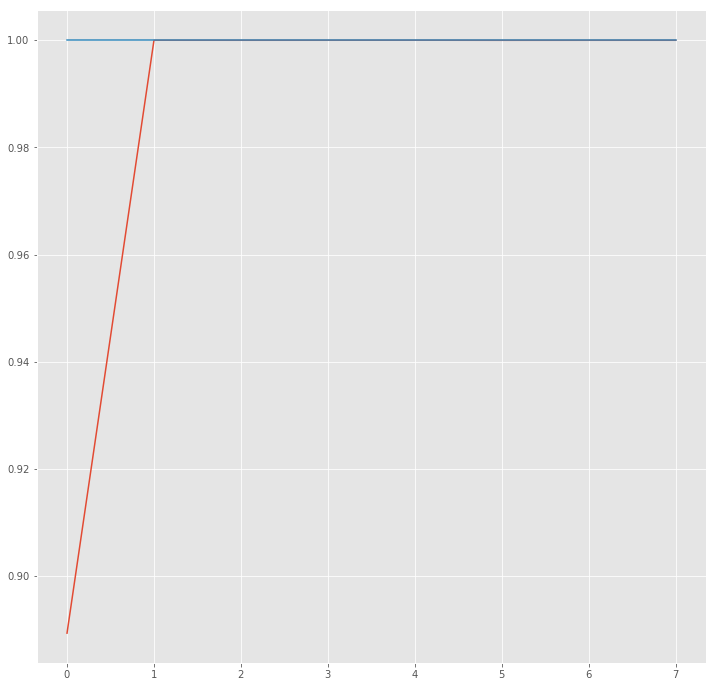

In [49]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [50]:
i = 0
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))
        

Word           ||True ||Pred
Polydiallyldimethylammonium: NANO  NANO


In [51]:
#test_sentence = ["host-guest", "graphene", "xyz", "nanocomposite"]

In [52]:
from stanfordcorenlp import StanfordCoreNLP
import logging
import json

class StanfordNLP:
    def __init__(self, host='http://localhost', port=9000):
        self.nlp = StanfordCoreNLP(host, port=port,
                                   timeout=30000)  # , quiet=False, logging_level=logging.DEBUG)
        self.props = {
            'annotators': 'tokenize,ssplit,pos,lemma,ner,parse,depparse,dcoref,relation',
            'pipelineLanguage': 'en',
            'outputFormat': 'json'
        }

    def word_tokenize(self, sentence):
        return self.nlp.word_tokenize(sentence)

    def tokens_to_dict(_tokens):
        tokens = defaultdict(dict)
        for token in _tokens:
            tokens[int(token['index'])] = {
                'word': token['word'],
                'lemma': token['lemma'],
                'pos': token['pos'],
                'ner': token['ner']
            }
        return tokens


if __name__ == '__main__':
    sNLP = StanfordNLP()

text = "Materials materials nm Nanoscale Structure Review abcd xyz Author Asif"

print(sNLP.word_tokenize(text))
test = sNLP.word_tokenize(text)

['Materials', 'nm', 'Nanoscale', 'Structure', 'Review', 'abcd', 'xyz', 'Author', 'Asif']


In [53]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test]],padding="post", value=0, maxlen=max_len)
print(x_test_sent)

[[   0 2885 4450  732 2200    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]


In [54]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
Materials      : NANO 
nm             : NANO 
Nanoscale      : NANO 
Structure      : NANO 
Review         : NANO 
abcd           : NANO 
xyz            : NANO 
Author         : NANO 
Asif           : NANO 
